### Local Variance Estimation

When working with time series (observations of a natural sequential ordering) one often wishes to estimate the variance of the time series locally. This notebook will go over a collection of methods that can be utilized to create an estimator for the local variance (or volatility) function

In [1]:

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../")


PATH = "../../../taq_db/TAQ-Query-Scripts/data/features/2020-01-02/"
sys.path.append(PATH)
DATA_FILE = "AMZN_reconstructed_features.csv"


In [2]:
market_data = pd.read_csv(PATH + DATA_FILE, index_col=0, nrows=10000)
market_data.index = pd.to_datetime(market_data.index)

trade_data= market_data[market_data["Trade_Volume"] > 0]


In [3]:
regular_trades = trade_data[trade_data["Sale_Condition"] == "@   "]
regular_trades.head()

,Date,Exchange,Symbol,Trade_Volume,Trade_Price,Sale_Condition,Source_of_Trade,Trade_Correction_Indicator,Sequence_Number,Trade_Id,...,YearMonth,Imbalance,MOX_Identifier,Effective_Spread,Microprice,Imbalance_Weighted_Effective_Spread,Price_Impact,Realized_Spread,Midprice,Trade_Side
index,,,,,,,,,,,,,,,,,,,,,
2020-01-02 09:30:00.820,2020-01-02,D,AMZN,100.0,1874.5450,@,N,0.0,21402,140.0,...,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:00.948,2020-01-02,D,AMZN,100.0,1874.7425,@,N,0.0,24389,191.0,...,NaN,NaN,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:00.948,2020-01-02,D,AMZN,100.0,1874.7425,@,N,0.0,24286,185.0,...,NaN,NaN,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:01.040,2020-01-02,D,AMZN,100.0,1874.7400,@,N,0.0,24778,233.0,...,NaN,NaN,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:01.160,2020-01-02,D,AMZN,200.0,1874.9900,@,N,0.0,26914,252.0,...,NaN,NaN,151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


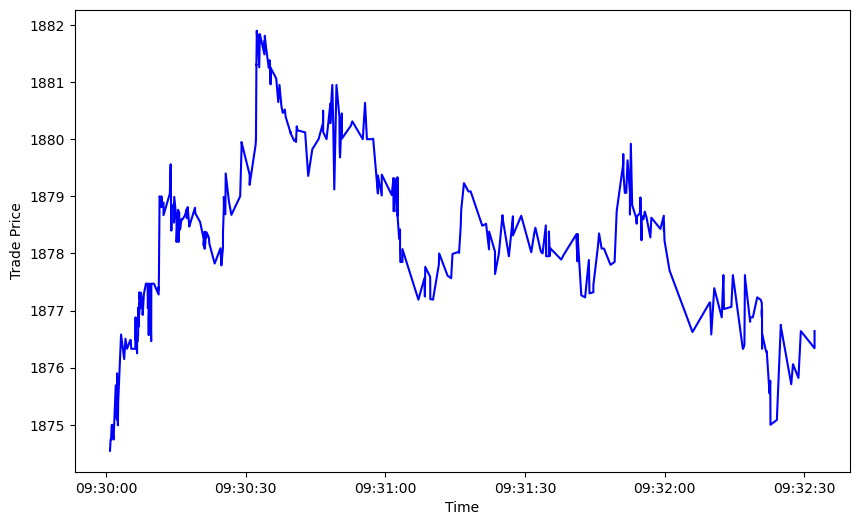

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(regular_trades.index, regular_trades["Trade_Price"], color="blue", label="Trade Price")

ax.set_xlabel("Time")
ax.set_ylabel("Trade Price")

plt.show()


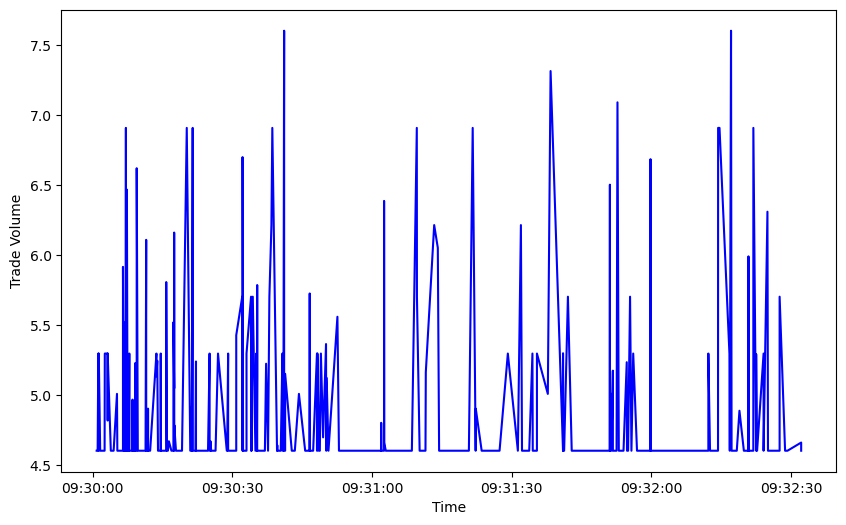

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(regular_trades.index, np.log(regular_trades["Trade_Volume"]), color="blue", label="Trade Volume")

ax.set_xlabel("Time")
ax.set_ylabel("Trade Volume")

plt.show()


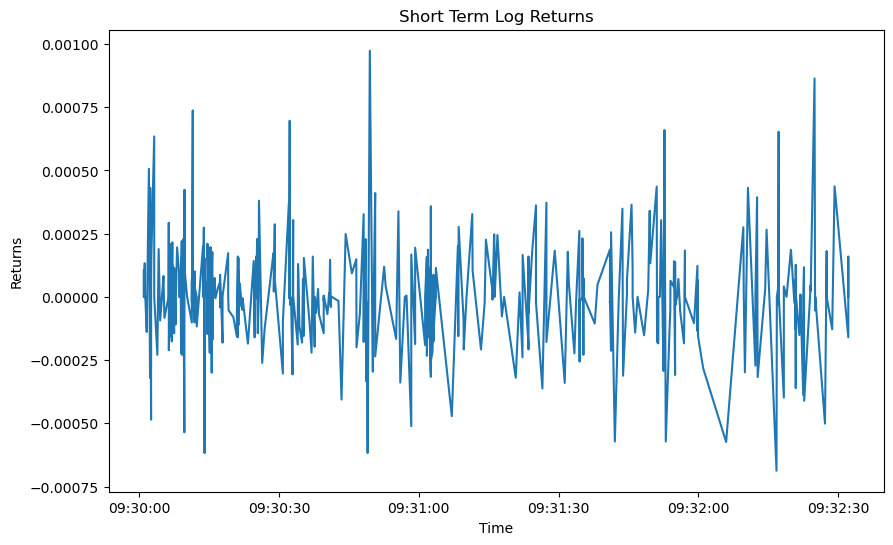

In [6]:
returns= np.log(regular_trades["Trade_Price"][1:].values/regular_trades["Trade_Price"][:-1].values)

returns=pd.Series(returns, index=regular_trades.index[1:])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(returns)
ax.set_title("Short Term Log Returns")
ax.set_xlabel("Time")
ax.set_ylabel("Returns")
plt.show()


### Local Variance Estimators

Assuming that $E[r_t] = 0$ for all $t$, the local variance of a time series $r_t$ is defined as

$$\sigma^2_t = \frac{1}{T}\sum_{i=1}^T r_i^2$$

where $T$ is the window size. This is the most basic estimator of the local variance, and is often referred to as the "naive" estimator. It is also known as the "sample variance" estimator. The sample variance estimator is unbiased, but has high variance. This is because the variance of the sample mean is proportional to $1/T$, and the variance of the sample variance is proportional to $1/T^2$. This means that the variance of the sample variance is proportional to $1/T$, which is why the sample variance estimator has high variance.

In [7]:
def sample_variance(returns, T):

    def compute_sample_variance(x):
        return (x**2).sum() / (T )
    return returns.rolling(T).apply(lambda x: compute_sample_variance(x))

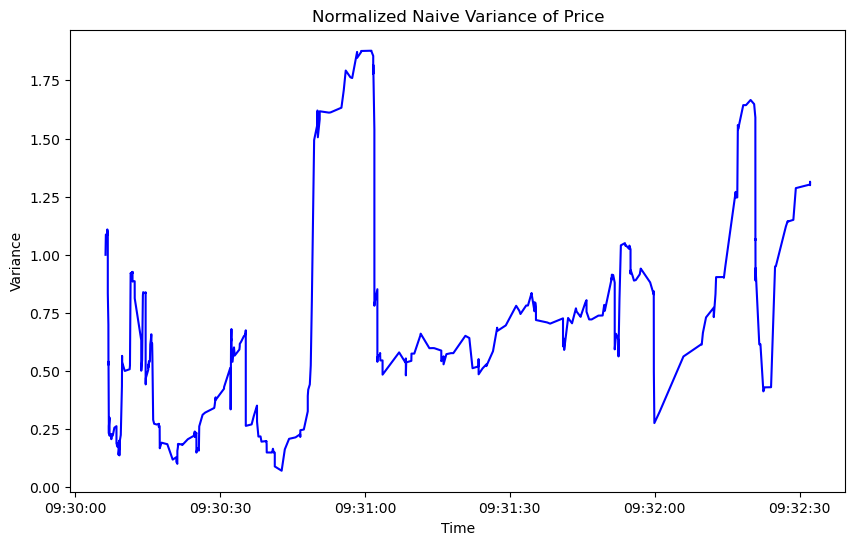

In [8]:
naive_variance = sample_variance(returns, 25).dropna()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(naive_variance.index, naive_variance.values/naive_variance.values[0], color="blue", label="Naive Variance")
ax.set_title("Normalized Naive Variance of Price")
ax.set_xlabel("Time")
ax.set_ylabel("Variance")
plt.show()



### Trade Volume

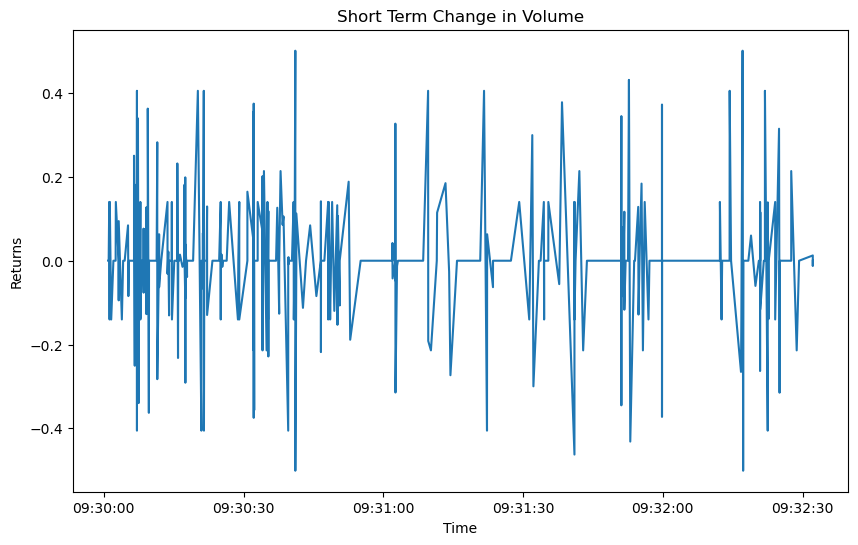

In [9]:
volume_returns = np.log(np.log(regular_trades["Trade_Volume"][1:].values)/np.log(regular_trades["Trade_Volume"][:-1].values))

volume_returns = pd.Series(volume_returns, index=regular_trades.index[1:])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(volume_returns)
ax.set_title("Short Term Change in Volume")
ax.set_xlabel("Time")
ax.set_ylabel("Returns")
plt.show()


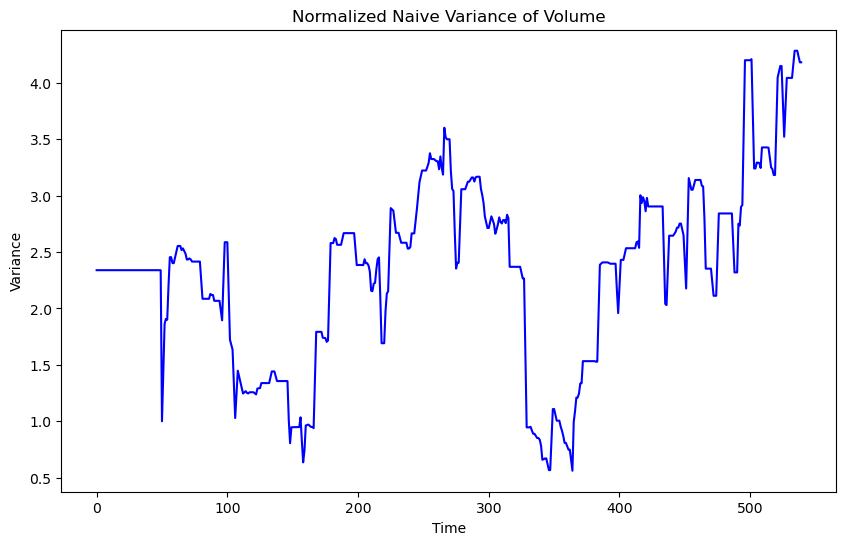

In [10]:
naive_volume_variance = sample_variance(volume_returns, 50).dropna()

volume_local_variance=naive_volume_variance/naive_volume_variance.values[0]

volume_local_variance=np.pad(volume_local_variance, (50,0), 'mean')

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot( volume_local_variance, color="blue", label="Naive Variance")
ax.set_title("Normalized Naive Variance of Volume")
ax.set_xlabel("Time")
ax.set_ylabel("Variance")
plt.show()



### Projecting the local variance estimator to much lower dimensional subspace (piecewise constant)

One way we can adaptively filter is by estimating the local variance of the exogenous covariate as a piecewise constant series. Using the TF to select optimal knots, one can then apply a DP search algorithm to select model

In [11]:
from estimators.regression.helpers.partition import partition_solver

In [12]:
candidate_knots=np.arange(0,len(volume_local_variance),100)

partition_solver(volume_local_variance,candidate_knots,10,0)

{1: [1],
 2: [1, 500],
 3: [1, 100, 500],
 4: [1, 100, 400, 500],
 5: [1, 100, 200, 300, 500],
 6: [1, 100, 200, 300, 400, 500],
 0: []}

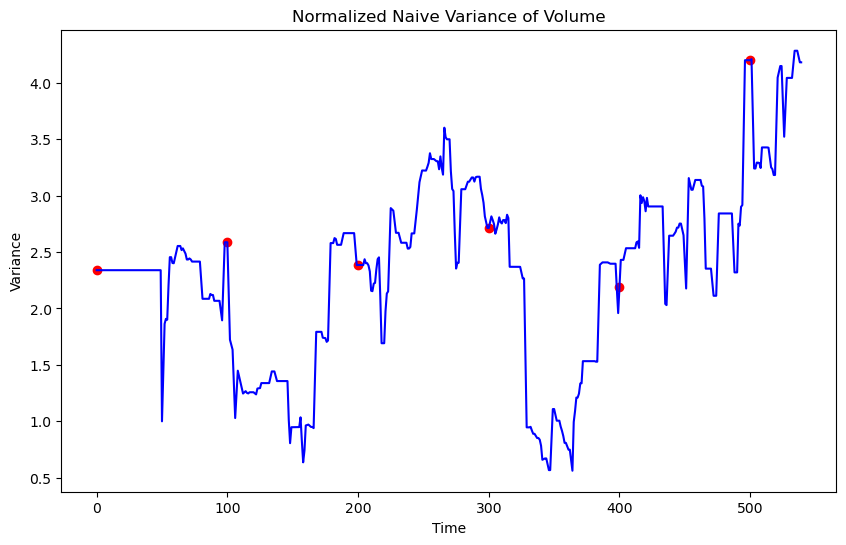

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot( volume_local_variance, color="blue", label="Naive Variance")
ax.set_title("Normalized Naive Variance of Volume")

ax.set_xlabel("Time")
ax.set_ylabel("Variance")

ax.scatter(candidate_knots, volume_local_variance[candidate_knots], color="red", label="Candidate Knots")

### Regression Trees

Decision Trees / Regression Trees are great models for generating piecewise constant estimates. They are also very easy to implement. The downside is that they are not very flexible, and can only generate piecewise constant estimates. This is a problem because the local variance is not piecewise constant. However, we can use the regression tree to generate a coarse estimate of the local variance, and then use this as an adaptive filter when trend filtering the time series.

In [14]:
from sklearn import tree


ModuleNotFoundError: No module named 'sklearn'

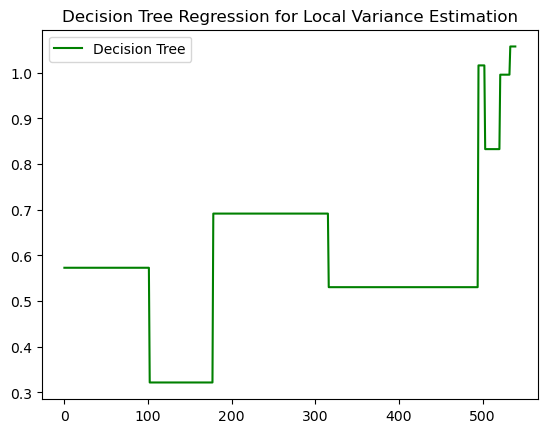

In [ ]:
model=tree.DecisionTreeRegressor(max_depth=3)

model.fit(np.arange(len(volume_local_variance)).reshape(-1,1), volume_local_variance)

predictions=model.predict(np.arange(len(volume_local_variance)).reshape(-1,1))/4

plt.title("Decision Tree Regression for Local Variance Estimation")

plt.plot(np.arange(len(volume_local_variance)), predictions, color="green", label="Decision Tree")

plt.legend()

### Effect of Volume Variance on Trend Filtering

In [20]:
import sys
sys.path.append("../")
from estimators.trend_filtering.trend_filter import Trend_Filter
from estimators.cv_base_estimator import cv_base_estimator

from estimators.regression.piecewise_polynomial import Piecewise_Polynomial_Model

In [18]:
trade_price=regular_trades["Trade_Price"].values

x=np.arange(len(trade_price))

tf=Trend_Filter(x,trade_price,k=1)


cv_base_estimator(tf)


Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 1.989717072979326
Performing cross validation for lambda = 3.8415422339214116
Performing cross validation for lambda = 7.4168568664411545
Performing cross validation for lambda = 14.319708707490088
Performing cross validation for lambda = 27.647029079820804
Performing cross validation for lambda = 53.37805625477918
Performing cross validation for lambda = 103.05689198330462
Performing cross validation for lambda = 198.9717072979326
Performing cross validation for lambda = 384.15422339214115
Performing cross validation for lambda = 741.6856866441154
Performing cross validation for lambda = 1431.9708707490072
Performing cross validation for lambda = 2764.7029079820804
Performing cross validation for lambda = 5337.8056254779185
Performing cross validation for lambda = 10305.68919833045
Performing cross validation for lambda = 19897.17072979326
Performing  1 out of 3 iterations of cross validatio

{'lambda_': 140.67261575450988}

In [21]:
regime_model=Piecewise_Polynomial_Model(x,trade_price,k=1,method="continous_tf")

[  9  97 124 305 419 450 479 525]
{1: [305], 2: [9, 305], 3: [9, 305, 479], 4: [9, 305, 419, 450], 5: [9, 305, 419, 450, 479], 6: [9, 305, 419, 450, 479, 525], 7: [9, 97, 305, 419, 450, 479, 525], 8: [9, 97, 124, 305, 419, 450, 479, 525], 0: []}
k: 0 mse: 2.209276095698971
k: 1 mse: 1.1210409187944808
k: 2 mse: 1.1022599137417148
k: 3 mse: 1.2417195845132267
k: 4 mse: 1.3358282569279267
k: 5 mse: 1.384143058357325
k: 6 mse: 1.5593417076352176
k: 7 mse: 1.844665316298235
k: 8 mse: 2.0528362939286606


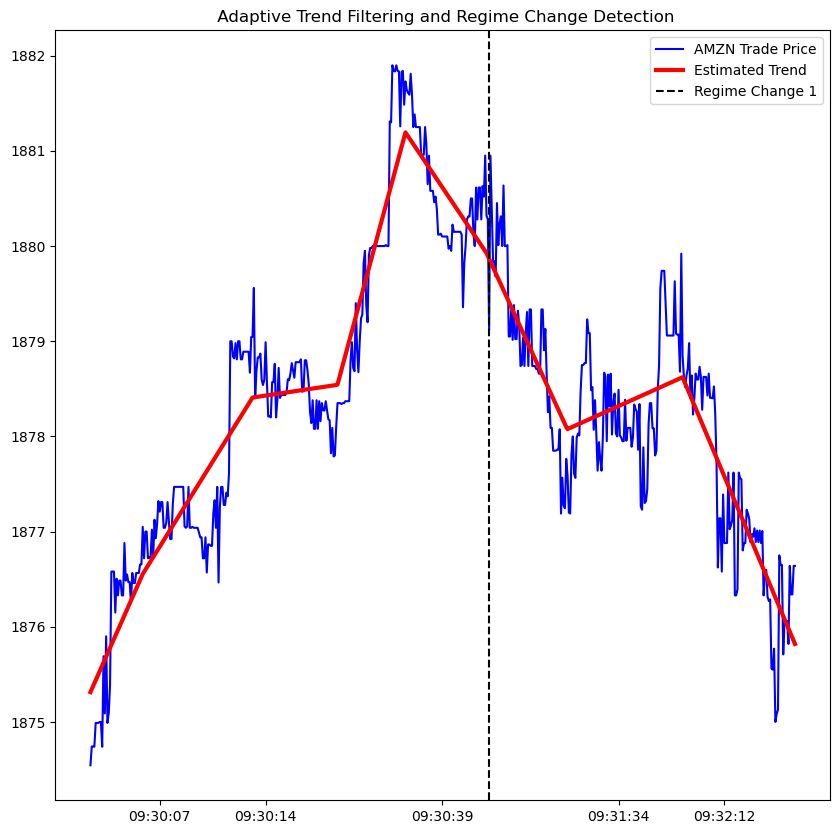

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price, label="AMZN Trade Price",color='blue')
ax.plot(tf.y_hat, label="Estimated Trend ",color='red',lw=3)

for i in range(len(regime_model.knots)):
    ax.axvline(regime_model.knots[i],color='black',linestyle='--',label=f"Regime Change {i+1}")

ax.legend()
ax.set_title(" Adaptive Trend Filtering and Regime Change Detection")

quantiles=[0.1,0.25,0.5,0.75,0.9]
indices=[int(len(trade_price)*q)-1 for q in quantiles]
ax.set_xticks(indices,regular_trades.index[indices].strftime("%H:%M:%S"))

### Adaptive Trend Filtering